<a href="https://colab.research.google.com/github/GustavFredrikson/Statistical-Machine-Learning/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt

import sklearn.model_selection as skl_ms
import sklearn.discriminant_analysis as skl_da
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train.head()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male


# Firstly using LDA and QDA with train test split 80% training 20% testing

In [4]:
train_1, test_1 = skl_ms.train_test_split(train, train_size=0.8, random_state=1)

y_train = train_1["Lead"]
x_train = train_1.drop(columns=["Lead"])
x_test = test_1.drop(columns=["Lead"])
y_test = test_1["Lead"]

In [5]:
model = skl_da.LinearDiscriminantAnalysis()
preds = model.fit(x_train, y_train)
print(f"Using LDA: \n Accuracy on train data: \t {preds.score(x_train, y_train)}")
print(f" Accuracy on test data: \t {preds.score(x_test, y_test)} \n\n")

Using LDA: 
 Accuracy on train data: 	 0.8628158844765343
 Accuracy on test data: 	 0.8894230769230769 




In [6]:
model = skl_da.QuadraticDiscriminantAnalysis()
preds = model.fit(x_train, y_train)

print(f"Using QDA: \n Accuracy on train data: \t {preds.score(x_train, y_train)}")
print(f" Accuracy on test data: \t {preds.score(x_test, y_test)}")

Using QDA: 
 Accuracy on train data: 	 0.9049338146811071
 Accuracy on test data: 	 0.875


# Implement using kfold 5 folds



Mean LDA on test data: 86.8%
Mean QDA on test data: 84.5%



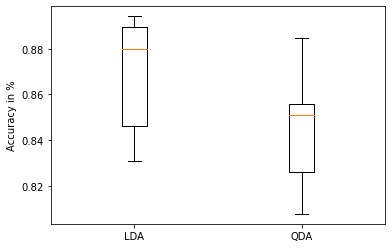

In [7]:
X = train.drop(columns=["Lead"])
y = train["Lead"]

kf = skl_ms.KFold(n_splits=5)

scores = {"LDA": [], "QDA": []}
for train_idx, test_idx in kf.split(train):
    x_train, x_val = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    scores["LDA"].append(skl_da.LinearDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))
    scores["QDA"].append(skl_da.QuadraticDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))

print(f"Mean LDA on test data: {round(statistics.mean(scores['LDA'])*100, 1)}%")
print(f"Mean QDA on test data: {round(statistics.mean(scores['QDA'])*100, 1)}%\n")

plt.boxplot([scores["LDA"], scores["QDA"]])
plt.xticks([1,2], ["LDA", "QDA"])
plt.ylabel("Accuracy in %")
plt.savefig('Boxplot LDA QDA.svg', format='svg')
# plt.show()

# Optimize Parameters

In [8]:
run_opti = False
if run_opti is True:
    X = train.drop(columns=["Lead"])
    y = train["Lead"]

    kf = skl_ms.KFold(n_splits=5) # 2 for regular test/train split

    solver = ["svd", "lsqr", "eigen"]
    shrinkage = ["auto", None]
    store_covariance = [True, False]
    tol = [float(x) for x in np.linspace(start=1e-5, stop=1, num=20)]
    random_grid = {
        'solver': solver,
        'shrinkage': shrinkage,
        'store_covariance': store_covariance,
        'tol': tol
    }

    rd_gridQDA = {
        'tol': tol
    }

    scores = {"LDA": [], "QDA": []}
    for train_idx, test_idx in kf.split(train):
        x_train, x_val = X.iloc[train_idx,:], X.iloc[test_idx,:]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        LDA = skl_da.LinearDiscriminantAnalysis()
        LDA_grid = GridSearchCV(estimator=LDA, param_grid=random_grid, cv=3, n_jobs=-1)
        LDA_grid.fit(x_train, y_train)
        # print('\nLDA\n', LDA_grid.best_params_)
        scores["LDA"].append(LDA_grid.score(x_val, y_val))

        QDA = skl_da.QuadraticDiscriminantAnalysis()
        QDA_grid = GridSearchCV(estimator=QDA, param_grid=rd_gridQDA, cv=3, n_jobs=-1)
        QDA_grid.fit(x_train, y_train)
        # print('\nQDA:\n', QDA_grid.best_params_)
        scores["QDA"].append(QDA_grid.score(x_val, y_val))

    print(f"Mean LDA on test data: {round(statistics.mean(scores['LDA'])*100, 1)}%")
    print(f"Mean QDA on test data: {round(statistics.mean(scores['QDA'])*100, 1)}%\n")

    plt.boxplot([scores["LDA"], scores["QDA"]])
    plt.xticks([1,2], ["LDA", "QDA"])
    plt.show()

Did not give any better result...

# Feature Importance

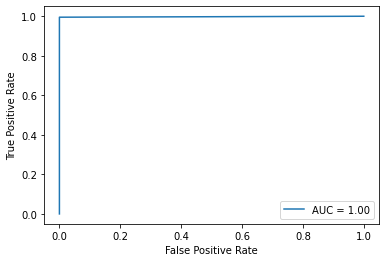

rocauc = (array([0.        , 0.56097561, 1.        ]), array([0.        , 0.97005988, 1.        ]), array([2, 1, 0]))
Variable used: Total words
Using LDA: 
 Accuracy on train data: 	 0.9963898916967509
 Accuracy on test data: 	 0.8653846153846154 




In [9]:
le = LabelEncoder()

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train_1, test_1 = skl_ms.train_test_split(train, train_size=0.8, random_state=1)

y_train = train_1["Lead"]
x_train = train_1.drop(columns=["Lead"])
x_test = test_1.drop(columns=["Lead"])
y_test = test_1["Lead"]

le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

i = 1

cols = x_train.columns
all = cols

x_val = x_test[cols]
X = x_train[cols]
y = y_train

model = RandomForestClassifier(bootstrap=False, max_depth=110, max_features='auto',
                               min_samples_leaf=2, min_samples_split=10, n_estimators=800)
model.fit(X, y)

fpr, tpr, thresholds = roc_curve(model.predict(X), y)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

print(f"rocauc = {roc_curve(y_test, model.predict(x_val))}")

print(f"Variable used: {cols[i]}")
print(f"Using LDA: \n Accuracy on train data: \t {model.score(X,y)}")
print(f" Accuracy on test data: \t {model.score(x_val, y_test)} \n\n")

In [10]:
model = RandomForestClassifier(bootstrap=False, max_depth=110, max_features='auto',
                            min_samples_leaf=2, min_samples_split=10, n_estimators=800)
model.fit(X, y)

print("Feature importance: ")

lst = list(model.feature_importances_)
lst.sort(reverse=True)
unsorted = {model.feature_importances_[i]: all[i] for i in range(len(all))}
sorted = {unsorted[i]: i for i in lst}

print("Most to least important features:\n")
for key, val in sorted.items():
    print(f"Feature: {key}, importance {round(val, 3)}")

Feature importance: 
Most to least important features:

Feature: Number words female, importance 0.162
Feature: Number of female actors, importance 0.126
Feature: Age Co-Lead, importance 0.099
Feature: Age Lead, importance 0.099
Feature: Difference in words lead and co-lead, importance 0.099
Feature: Number of male actors, importance 0.079
Feature: Number words male, importance 0.071
Feature: Mean Age Female, importance 0.052
Feature: Number of words lead, importance 0.051
Feature: Total words, importance 0.05
Feature: Mean Age Male, importance 0.048
Feature: Gross, importance 0.032
Feature: Year, importance 0.03


### Get coefficients of logistic regression

In [11]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train_1, test_1 = skl_ms.train_test_split(train, train_size=0.8, random_state=1)

y_train = train_1["Lead"]
x_train = train_1.drop(columns=["Lead"])
x_test = test_1.drop(columns=["Lead"])
y_test = test_1["Lead"]

le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

all = ["Number words female", "Number words male", "Year", "Gross"]
i = 1
cols = all

x_val = x_test[cols]
X = x_train[cols]
y = y_train

pipe = make_pipeline(StandardScaler(),LogisticRegression())
pipe.fit(X,y)

print(pipe.score(x_val,y_test))
classifier = pipe.named_steps['logisticregression']
classifier.coef_

0.8028846153846154


array([[ 0.14504212,  0.07258681, -0.17842515,  0.0017353 ]])

Mean LDA on test data: 86.7%
Mean QDA on test data: 89.6%



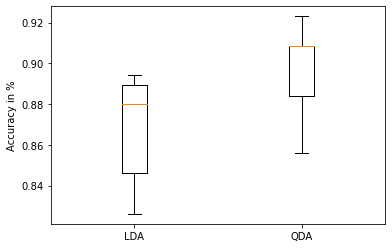

In [12]:
X = train.drop(columns=["Lead", "Gross","Year","Total words"])
y = train["Lead"]

kf = skl_ms.KFold(n_splits=5)

scores = {"LDA": [], "QDA": []}
for train_idx, test_idx in kf.split(train):
    x_train, x_val = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    scores["LDA"].append(skl_da.LinearDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))
    scores["QDA"].append(skl_da.QuadraticDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))

print(f"Mean LDA on test data: {round(statistics.mean(scores['LDA'])*100, 1)}%")
print(f"Mean QDA on test data: {round(statistics.mean(scores['QDA'])*100, 1)}%\n")

plt.boxplot([scores["LDA"], scores["QDA"]])
plt.xticks([1,2], ["LDA", "QDA"])
plt.ylabel("Accuracy in %")
plt.savefig('Boxplot LDA QDA.svg', format='svg')
# plt.show()